# Backtesting

This notebook will perform the backtesting of our SVM model on our dataset. 

We will calculate the total profit/loss of our strategy, as well as information about the trading frequency, the profit per trade, and other information about the performance of our strategy. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import datetime

import math
import scipy.stats
import sklearn
from sklearn import preprocessing
from sklearn import svm

%load_ext autoreload
%autoreload 2

In [3]:
# Load in dataset
df_ua = pd.read_csv('./data/df_ua_processed.csv')
df_uaa = pd.read_csv('./data/df_uaa_processed.csv')

# Read in train-test fold data
info = np.load('./data/info.npy', allow_pickle=True)

In [9]:
def create_pl_df(df_ticker1, df_ticker2, info):
    """
    Creates a comprehensive DataFrame by combining the ticker data from the given tickers 
    with the residual information calculated in the OU class. 

    Saves this DataFrame to self.df_residual. 
    
    ## TODO: Rewrite UA/UAA Labels to make more abstract. 

    :df_ticker1: ticker data from first asset. 
    :df_ticker2: ticker data from second asset. 
    :info: Fold dictionary calculated from OU class. 

    """
    ticker1_name = df_ticker1['ticker']
    ticker2_name = df_ticker2['ticker']
    
    df_test_only = pd.DataFrame()
    df_test_only_labels = pd.Series()

    for i in info:
        idx = i['test']['index']
        residuals = i['test']['residuals_transform_price']
        beta = i['train']['beta_fit_price']
        df_temp = pd.concat([df_ticker1.loc[idx]['close'], 
                             beta * df_ticker2.loc[idx]['close'], 
                             df_ticker1.loc[idx]['price'], 
                             beta * df_ticker2.loc[idx]['price'], 
                             i['test']['residuals_transform_price'], 
                             df_ticker1.loc[idx]['TIMESTAMP']
                            ], axis=1)
        df_test_only = df_test_only.append(df_temp)
        df_test_only_labels = df_test_only_labels.append(i['test']['labels'])

    df_test_only['label'] = df_test_only_labels
    df_test_only.columns=['UA', 'beta*UAA', 'UA_return', 
                          'beta*UAA_return', 'residual', 'TIMESTAMP', 'label']
    # Find Profit of last trade given percent returns. 
    # (y-(1-deltaY)y) - (x-(1-deltaX)x)
    df_test_only['beta*UAA_gains'] = df_test_only['beta*UAA']-(1-df_test_only['beta*UAA_return'])*df_test_only['beta*UAA']
    df_test_only['UA_gains'] = df_test_only['UA']-(1-df_test_only['UA_return'])*df_test_only['UA']
    df_test_only['profit'] = df_test_only['beta*UAA_gains'] - df_test_only['UA_gains']
    df_test_only['TIMESTAMP'] = pd.to_datetime(df_test_only.TIMESTAMP)
    print('P/L Dataframe saved as "df_residual" parameter.')
    return df_test_only

In [10]:
def param_format(params):
    """
    Function that formats a dictionary of parameters into a string that is 
    writeable to a file/directory. 
    
    :params: Parameter Dictionary to format. 
    
    :ret: Stringified version of the parameter dictionary. 
    """
    param_str = ', '.join("{!s}-{!r}".format(key,val) for (key,val) in params.items())
    param_str = param_str.replace("{", "")
    param_str = param_str.replace("}", "")
    param_str = param_str.replace("'", "")
    param_str = param_str.replace(",", "_")
    param_str = param_str.replace(" ", "")
    param_str = param_str.replace(":", "")
    param_str = param_str.replace(".", "")
    param_str = param_str.strip()
    
    return param_str

In [11]:
def sharpe(df_temp):
    """
    Takes in a profit/loss dataframe with labels and finds the Sharpe Ratio according to 
    the following formula: 
    
    Daily P/L / Standard Dev(Daily P/L) x sqrt(252)
    
    :df_temp: Profit/loss dataframe. 
    
    :ret: Sharpe Ratio.
    """
    daily_profit = df_temp.groupby(by = 
                                   [df_temp.TIMESTAMP.dt.year, 
                                    df_temp.TIMESTAMP.dt.month, 
                                    df_temp.TIMESTAMP.dt.day])['profit_timeline'].sum()
    
    return np.mean(daily_profit)/np.std(daily_profit) * np.sqrt(252)


def sortino(df_temp):
    """
    Takes in a profit/loss dataframe with labels and finds the Sortino Ratio according to 
    the following formula: 
    
    Daily P/L / Standard Dev(Negative Daily P/L) x sqrt(252)
    
    :df_temp: Profit/loss dataframe. 
    
    :ret: Sortino Ratio.
    """
    daily_profit = df_temp.groupby(by = 
                                   [df_temp.TIMESTAMP.dt.year, 
                                    df_temp.TIMESTAMP.dt.month, 
                                    df_temp.TIMESTAMP.dt.day])['profit_timeline'].sum()
    
    return np.mean(daily_profit)/np.std([pl for pl in daily_profit if pl < 0]) * np.sqrt(252)
    

def precision(pred, label):
    return (pred[np.logical_and(pred==1, label==1)].shape[0])/pred[pred==1].shape[0]


def fit(params, info):
    """
    Fit a SVM according to the parameters across all folds in the info dictionary. 
    Returns a flattened numpy array of prediction labels across all folds. 

    Adds the labels for the parameter to the residual graph. 

    :params: Model Hyperparameters.
    :info_dict: Associated Info Dict.

    :ret: Numpy array of predictions.
    """
    preds = []

    for i in info:
        b_svm = svm.SVC(**params)
        b_svm.fit(i['train']['df_scale'], i['train']['labels'])
        pred = b_svm.predict(i['test']['df_scale'])
        preds.append(pred)
        
    return np.hstack(np.array(preds))


def find_profit_loss(df_test, preds, params, window=5, threshold=0.0005, plot=True, save_dir=None):
    """
    Performs P/L Backtesting given some prediction labels and a test dataframe. 

    Returns a dictionary of results. 
    
    :df_test: DataFrame of profit loss. 
    :preds: Prediction Labels: 
    :params: Name of Params of model tested. 
    :window: Evaluation window for how long we want to hold on to our position. 
    :threshold: how much of a residual shift determines a trade being offloaded. 
    :plot: Flag for evaluation plots. 
    :save_dir: Folder to save evaluation plots. 
    
    :ret: results. 
    """
    backtest_results = {}
    # Turn params into string for file output
    param_str = param_format(params)
    print("Finding Profit/Loss for model with parameters: %s." % param_str)
    total_profit = 0.0
    
    # Daily profit p/l
    profit_timeline = []
    # Per trade p/l
    trade_profit_timeline = []
    # Amount of minutes held per trade
    time_held_timeline = []
    # Trades held portfolio
    trades_data = []

    df_temp = df_test.copy()
    df_temp['label'] = preds

    for row in df_temp.iterrows():
        cur_profit = 0.0
        profit = row[1]['profit']
        residual = row[1]['residual']
        
        # For each currently held trade in portfolio, adjust freshness and profit with each timestep. 
        for position in trades_data:
            position['fresh'] += 1
            position['profit'] += profit
            # If the residual crosses the threshold or the time runs out, unload the trade. 
            if (position['residual'] - threshold >= residual) or position['fresh'] >= window:
                cur_profit+=position['profit']
                # To keep track of average trade value. 
                trade_profit_timeline.append(position['profit'])
                time_held_timeline.append(position['fresh'])
                trades_data.remove(position)
        profit_timeline.append(cur_profit)
        total_profit+=cur_profit

        if row[1]['label']==1 and residual > 0:
            trades_data.append({'profit': 0, 'residual': residual, 'fresh': 0})
            
    # Appends daily p/l array to array for easier calculations in the future.         
    df_temp['profit_timeline'] = profit_timeline
    
    backtest_results['total_profit'] = total_profit
    backtest_results['daily_profit_timeline'] = profit_timeline
    backtest_results['trade_profit_timeline'] = trade_profit_timeline
    backtest_results['time_held_timeline'] = time_held_timeline
    backtest_results['trades_executed'] = len(trade_profit_timeline)
    backtest_results['params'] = params
    backtest_results['precision'] = precision(df_temp['label'], df_test['label'])
    backtest_results['mean_profit_per_trade'] = np.mean(trade_profit_timeline)
    backtest_results['sharpe'] = sharpe(df_temp)
    backtest_results['sortino'] = sortino(df_temp)
    
    if plot:
        # Plot Total Profit
        min_date = df_temp.TIMESTAMP.min()
        max_date = df_temp.TIMESTAMP.max()
        plt.figure(figsize=(12, 8))
        plt.plot(np.cumsum(profit_timeline), color='green')
        plt.xlabel('Time')
        plt.ylabel('P/L')
        plt.xlim([0, df_temp.shape[0]])
        plt.ylim([-2000, 12000])
        plt.title('Total P/L from %s to %s \n Window=%d, threshold = %0.5f \n Model Parameters: %s' % (min_date, max_date, window, threshold, params))
        plt.grid()
        plt.tight_layout()
        plt.savefig(save_dir + 'total_pl_' + param_str +'.jpg')

        # Plot Time Held Histogram
        plt.figure(figsize=(12, 8))
        plt.hist(time_held_timeline, bins=5, linestyle='solid', edgecolor='black', color='red')
        ax = plt.gca()
        plt.xlabel('Histogram of Minutes held per trade')
        plt.ylabel('Frequency')
        plt.grid()
        plt.xlim([1, window])
        plt.title('Minutes held per trade \n Model Parameters: %s' % params)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        plt.tight_layout()
        plt.savefig(save_dir + param_str +'minutes_held_hist1.jpg')
        
        # Plot Minutes Held vs. Profit Scatter Plot
        plt.figure(figsize=(12, 8))
        ax = plt.gca()
        plt.scatter(trade_profit_timeline, time_held_timeline)
        plt.xlabel('Profit/Loss')
        plt.ylabel('Minutes Held')
        plt.title('Minutes Held vs. Profit/Loss')
        plt.grid()
        plt.tight_layout()
        ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
        plt.savefig(save_dir + param_str +'minutes_held_hist.jpg')
        
        # Average Trade Histogram
        plt.figure(figsize=(12, 8))
        ax = plt.gca()
        plt.hist(trade_profit_timeline, bins=1000)
        plt.xlabel('Profit/Loss')
        plt.ylabel('Frequency')
        plt.title('Histogram of Profit/Loss per Trade\n Average Trade: %0.4f\n Median Trade: %0.4f' % (np.mean(trade_profit_timeline), np.median(trade_profit_timeline)))
        plt.axvline(np.median(trade_profit_timeline), label='Median', linestyle='dashed')
        plt.grid()
        ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
        plt.tight_layout()
        plt.savefig(save_dir + param_str +'_average_trade_hist.jpg')
        
    return backtest_results


In [12]:
# Particular set of parameters for the SVM model that we want to backtest

params = {'C': 100,
   'cache_size': 2000,
   'class_weight': {0: 0.6, 1: 0.4},
   'gamma': 1,
   'kernel': 'rbf'}

In [13]:
df_pl = create_pl_df(df_ua, df_uaa, info)

/Users/xijiaqi/opt/anaconda3/envs/hft/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


P/L Dataframe saved as "df_residual" parameter.


In [14]:
labels = fit(params, info)

/Users/xijiaqi/opt/anaconda3/envs/hft/lib/python3.7/site-packages/ipykernel_launcher.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [15]:
save_dir = './plots/backtesting/'

Finding Profit/Loss for model with parameters: C-100_cache_size-2000_class_weight-006_104_gamma-1_kernel-rbf.


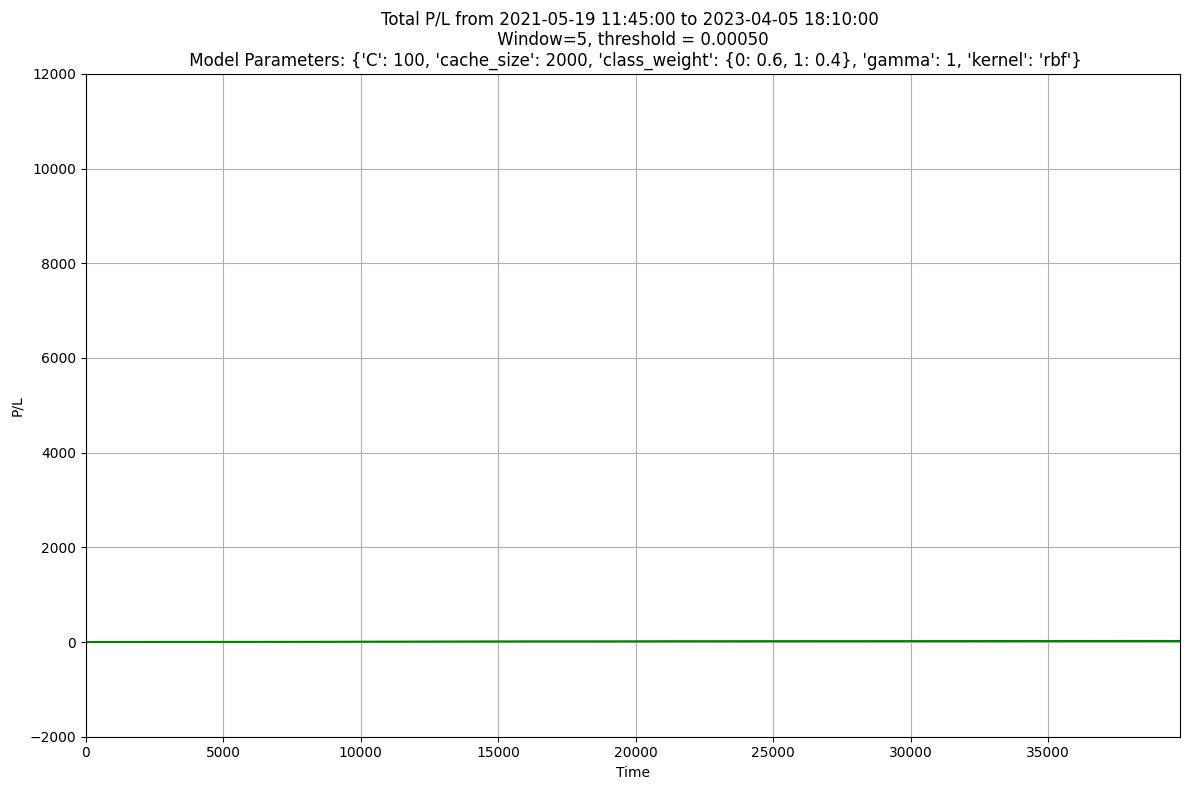

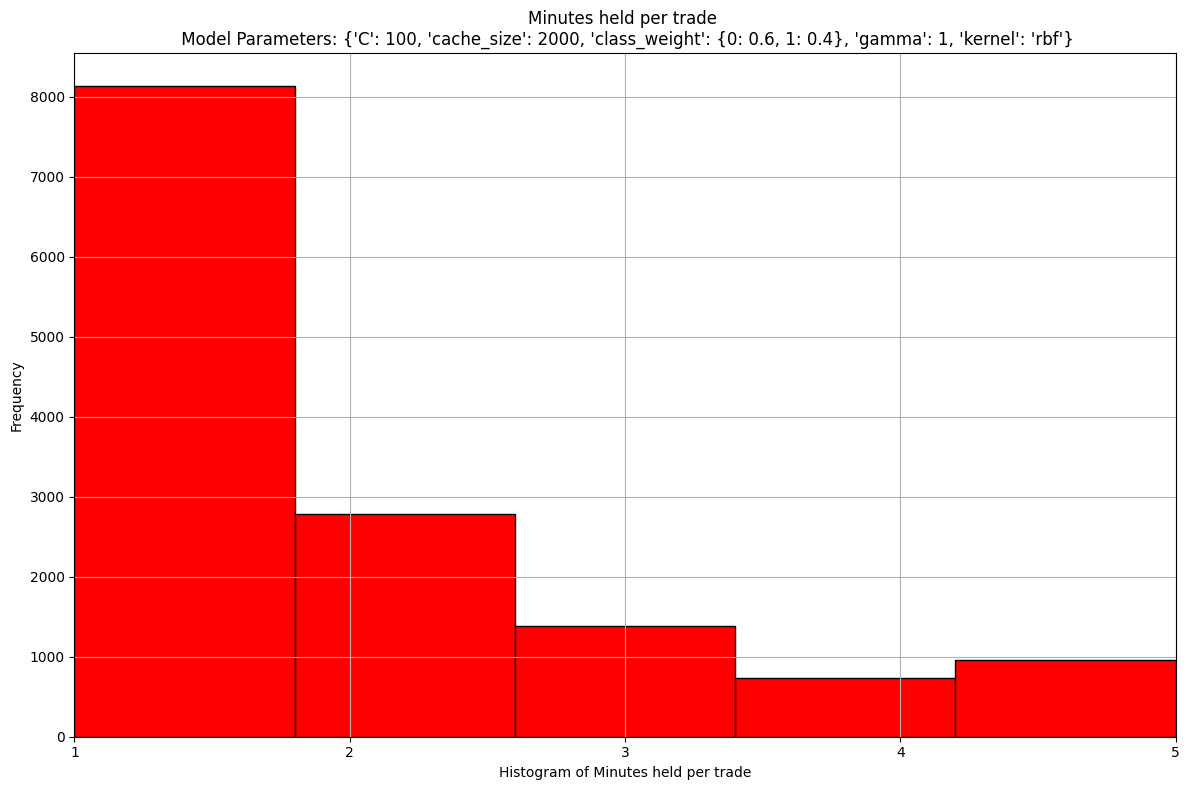

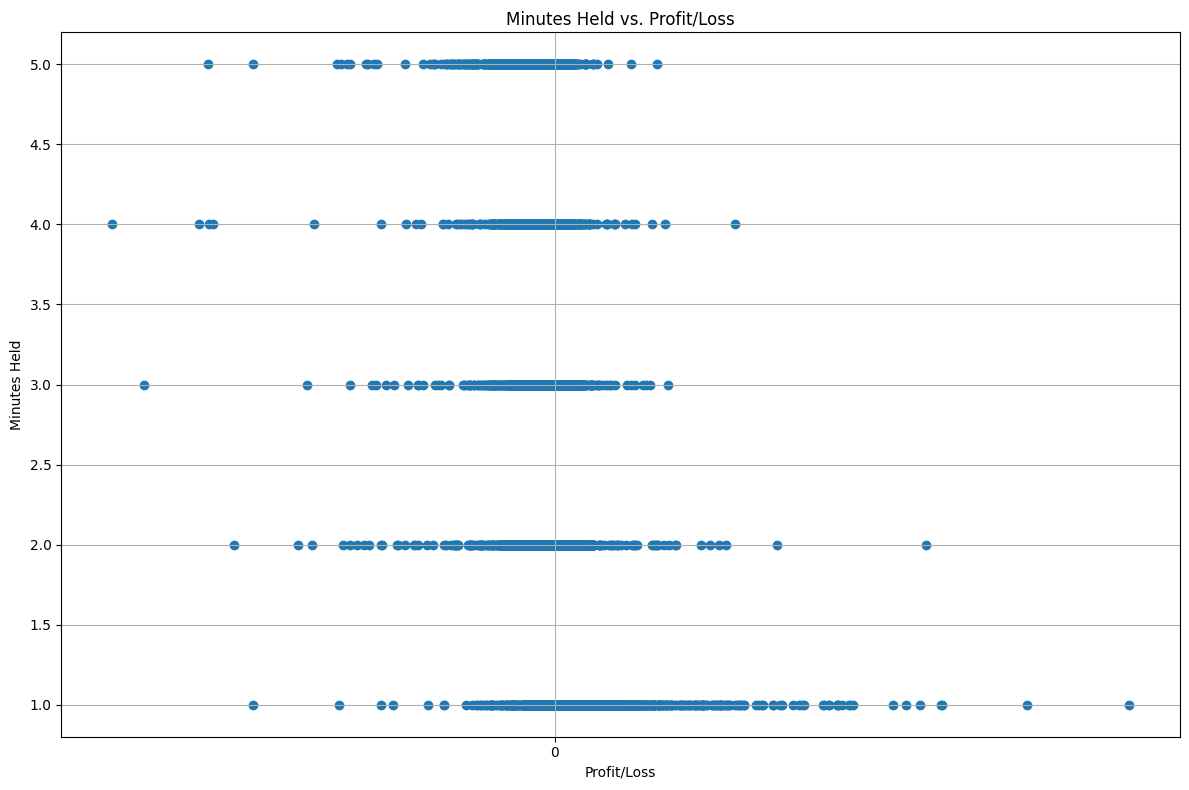

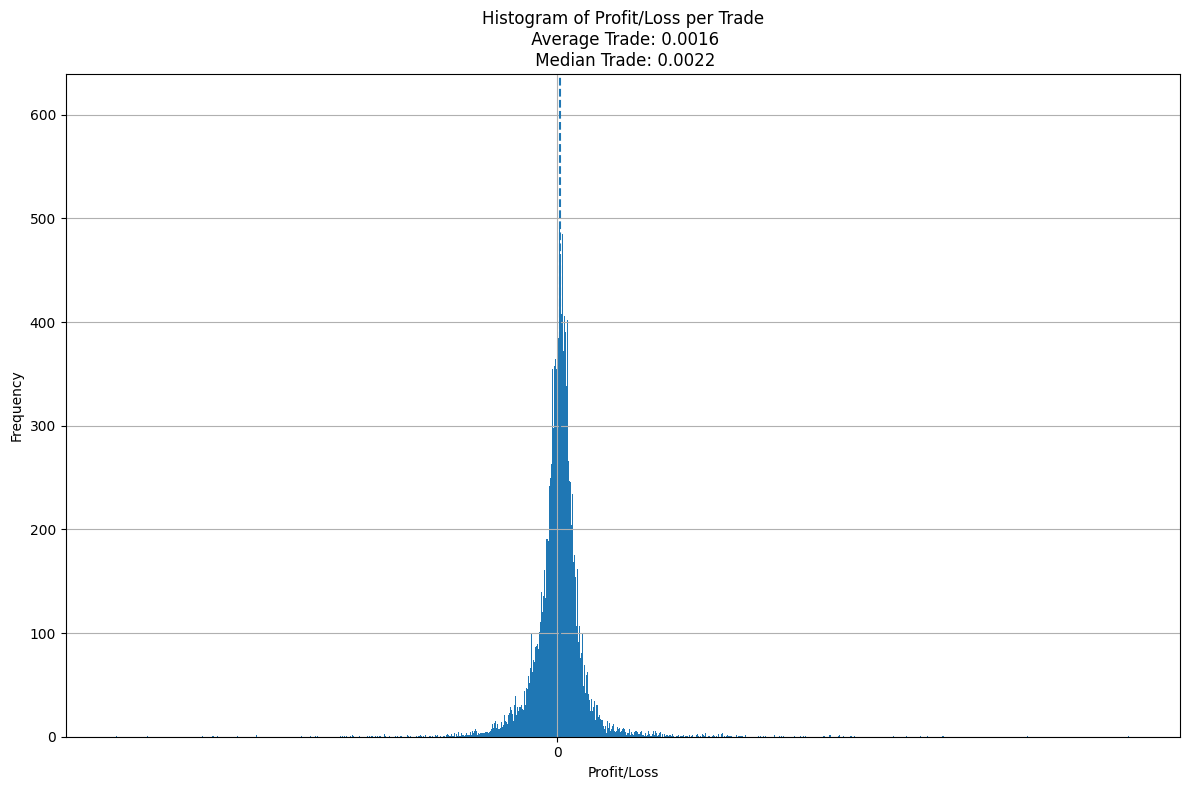

In [17]:
pl_info = find_profit_loss(df_pl, labels, params, save_dir=save_dir)

Finding Profit/Loss for model with parameters: C-100_cache_size-2000_class_weight-006_104_gamma-1_kernel-rbf.
Finding Profit/Loss for model with parameters: C-100_cache_size-2000_class_weight-006_104_gamma-1_kernel-rbf.
Finding Profit/Loss for model with parameters: C-100_cache_size-2000_class_weight-006_104_gamma-1_kernel-rbf.


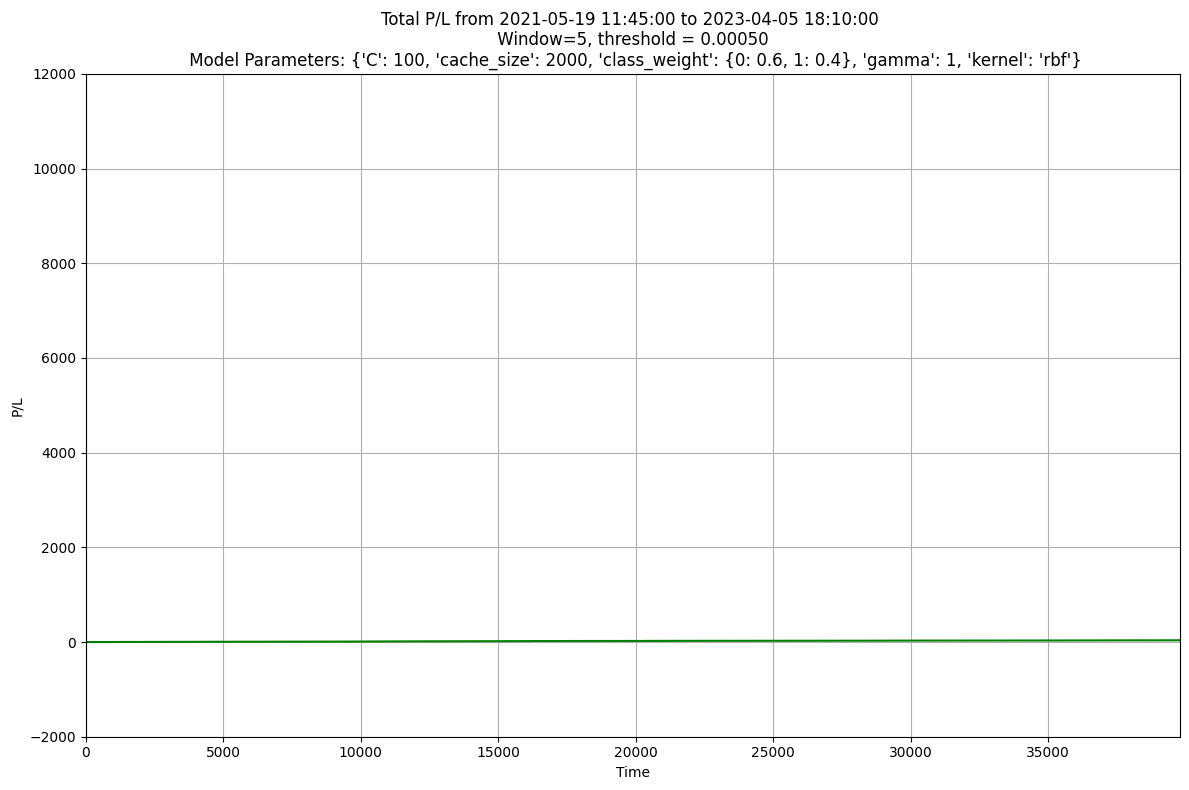

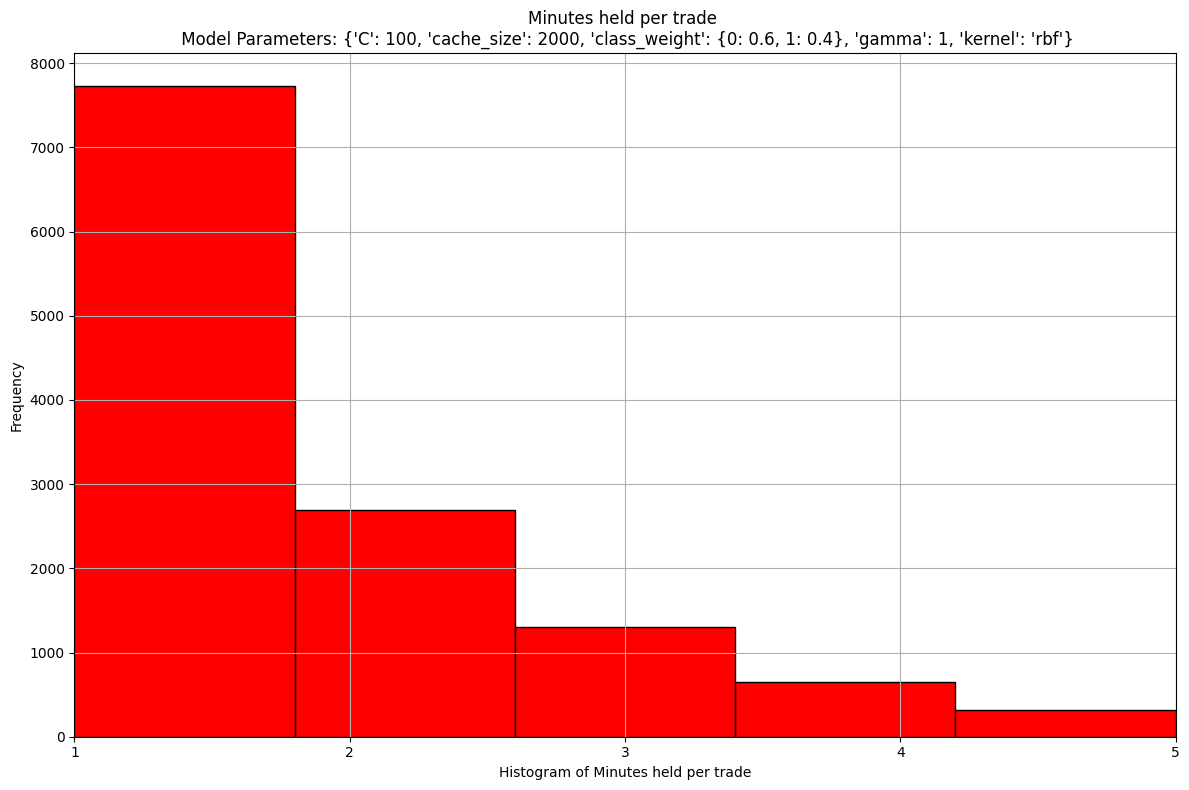

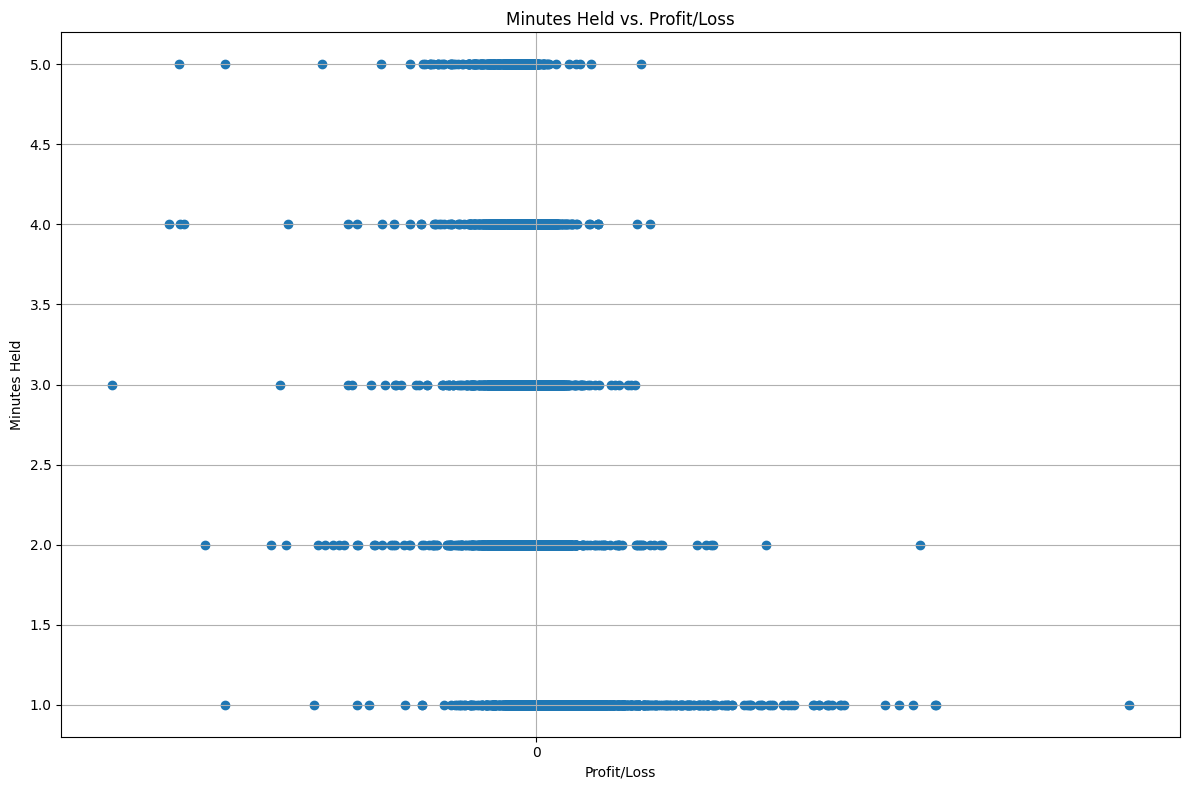

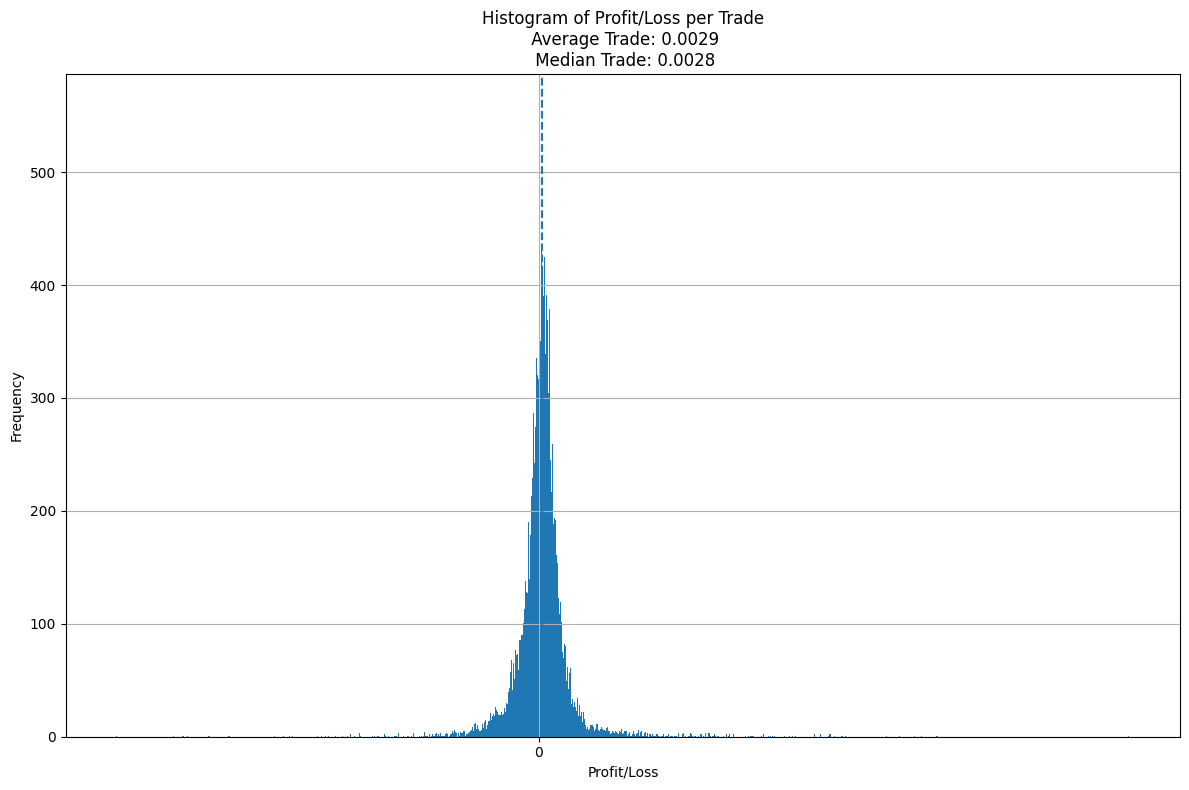

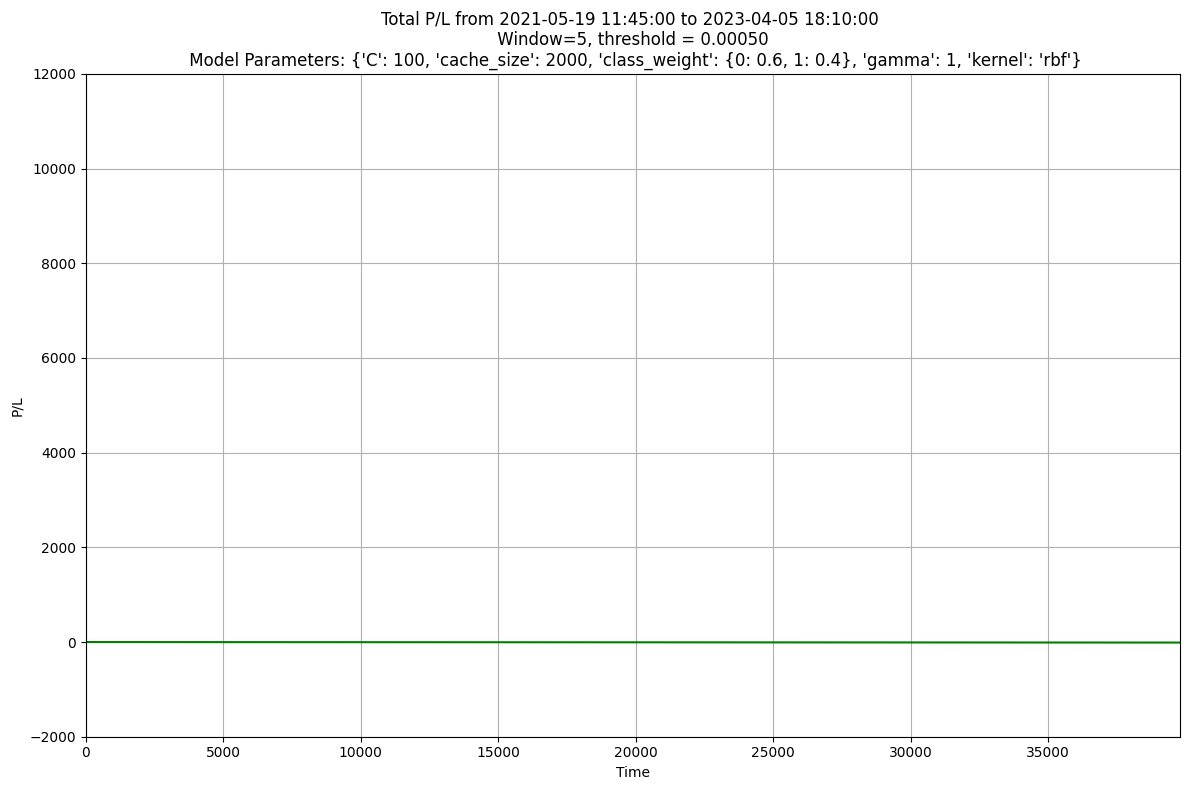

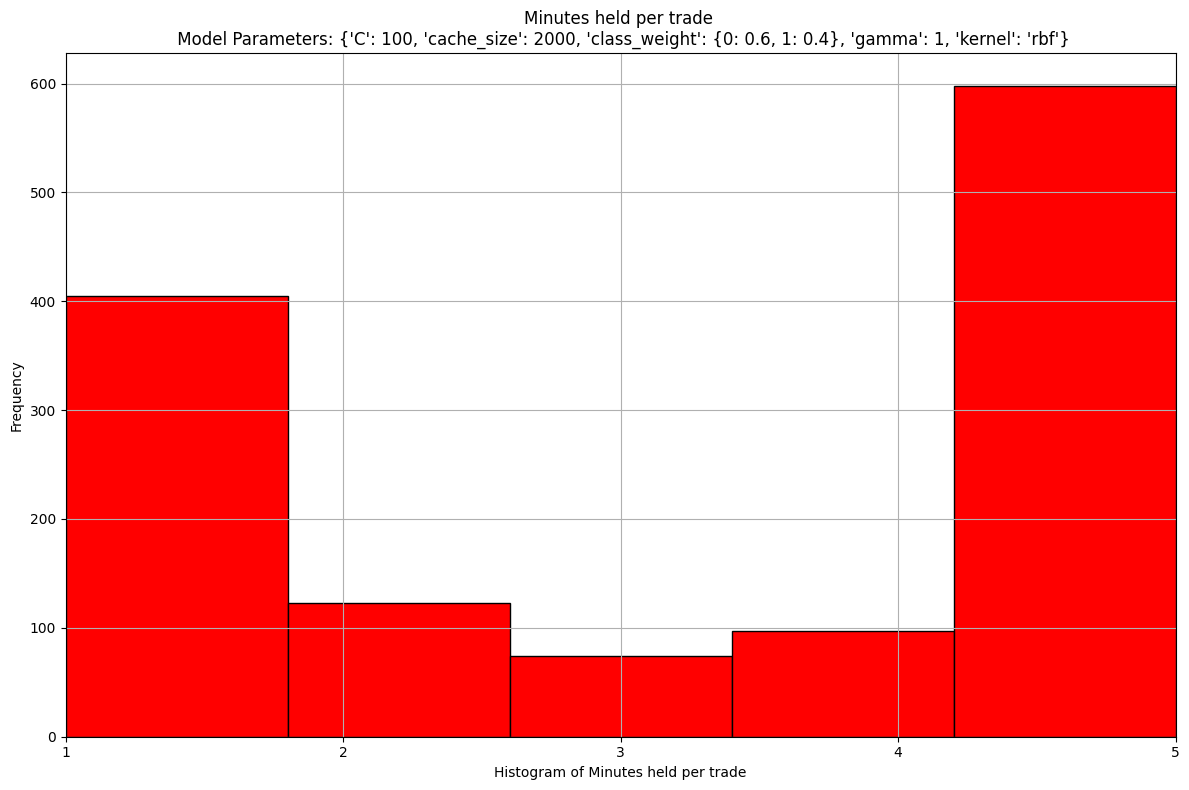

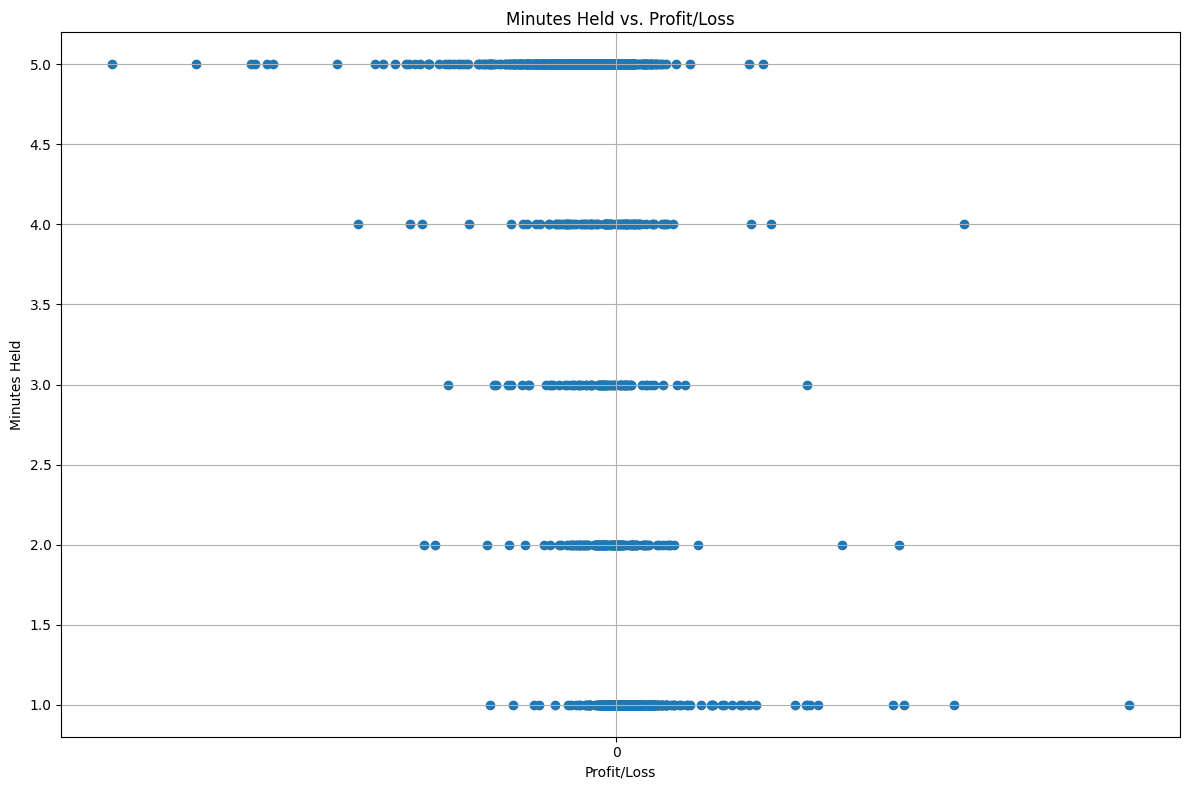

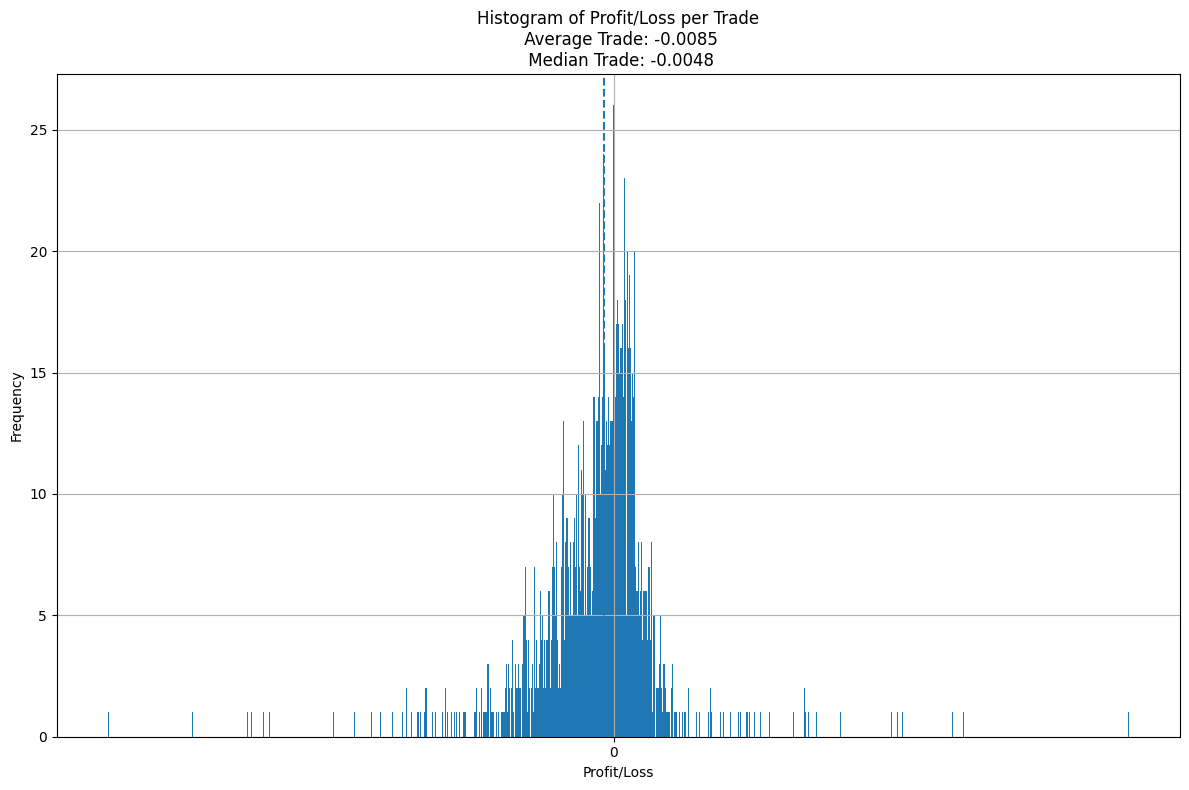

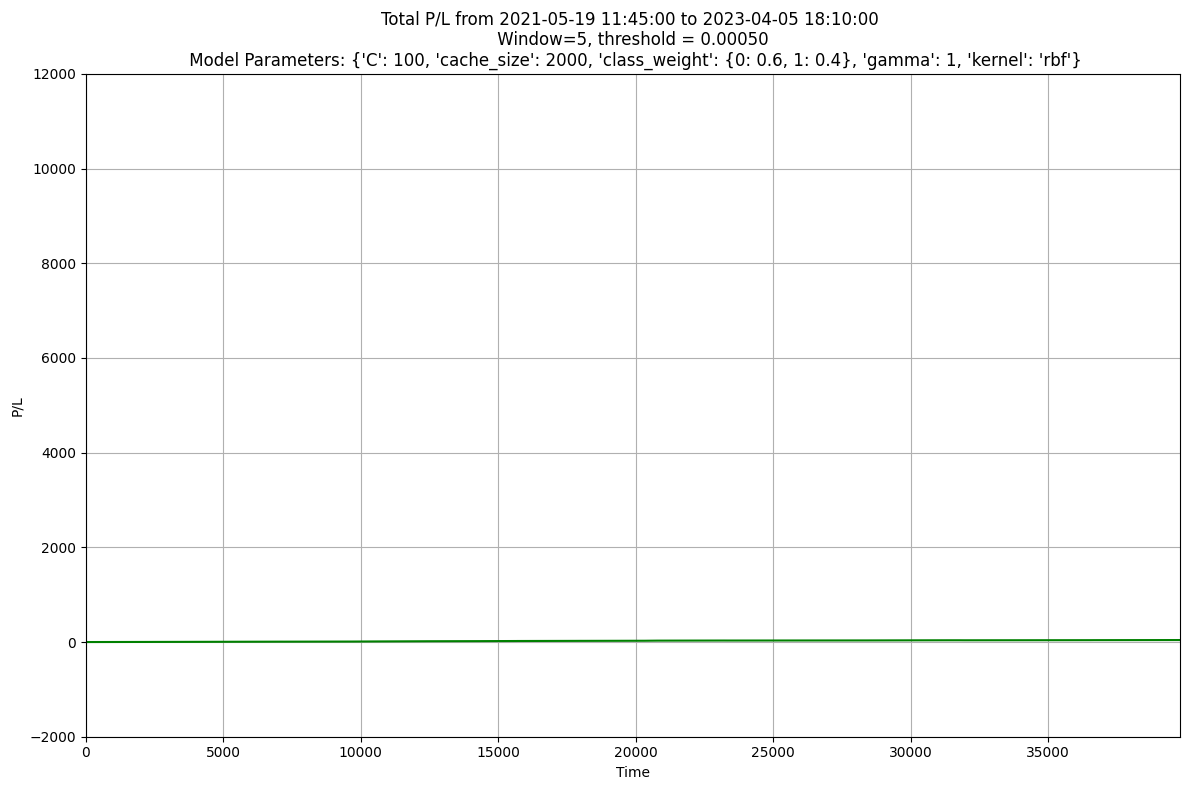

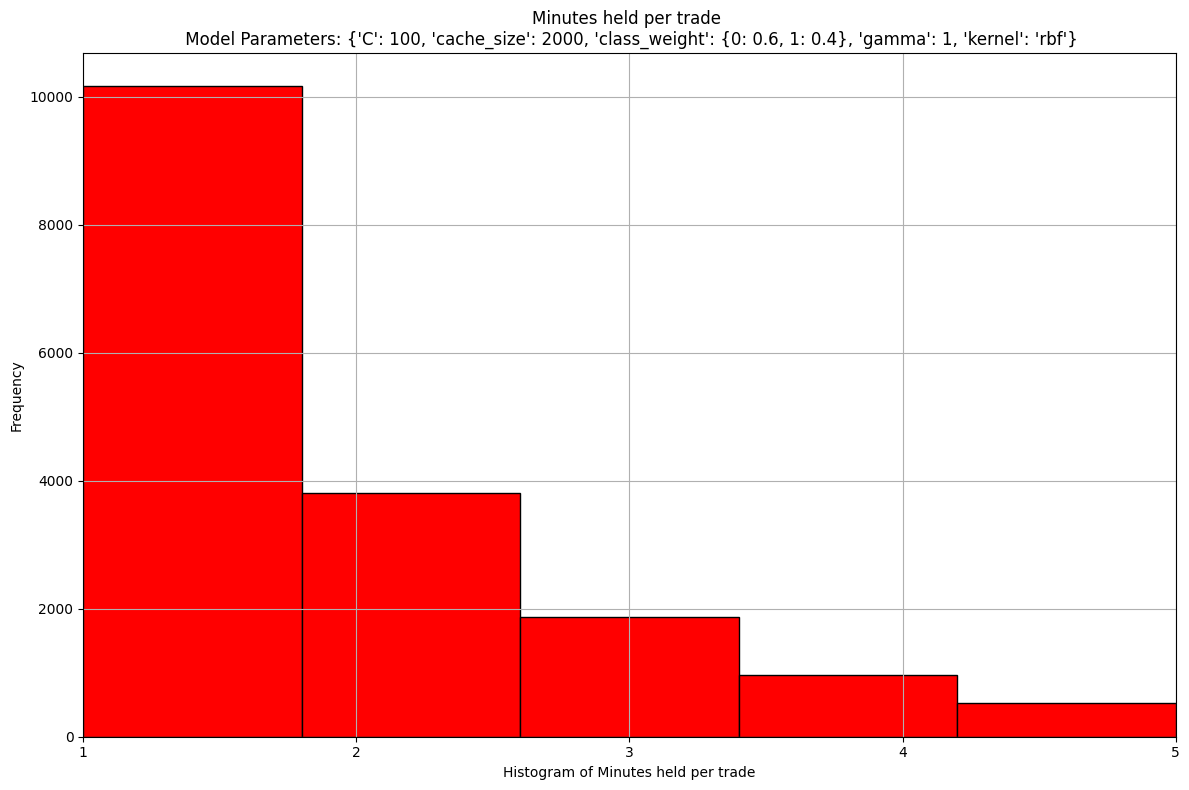

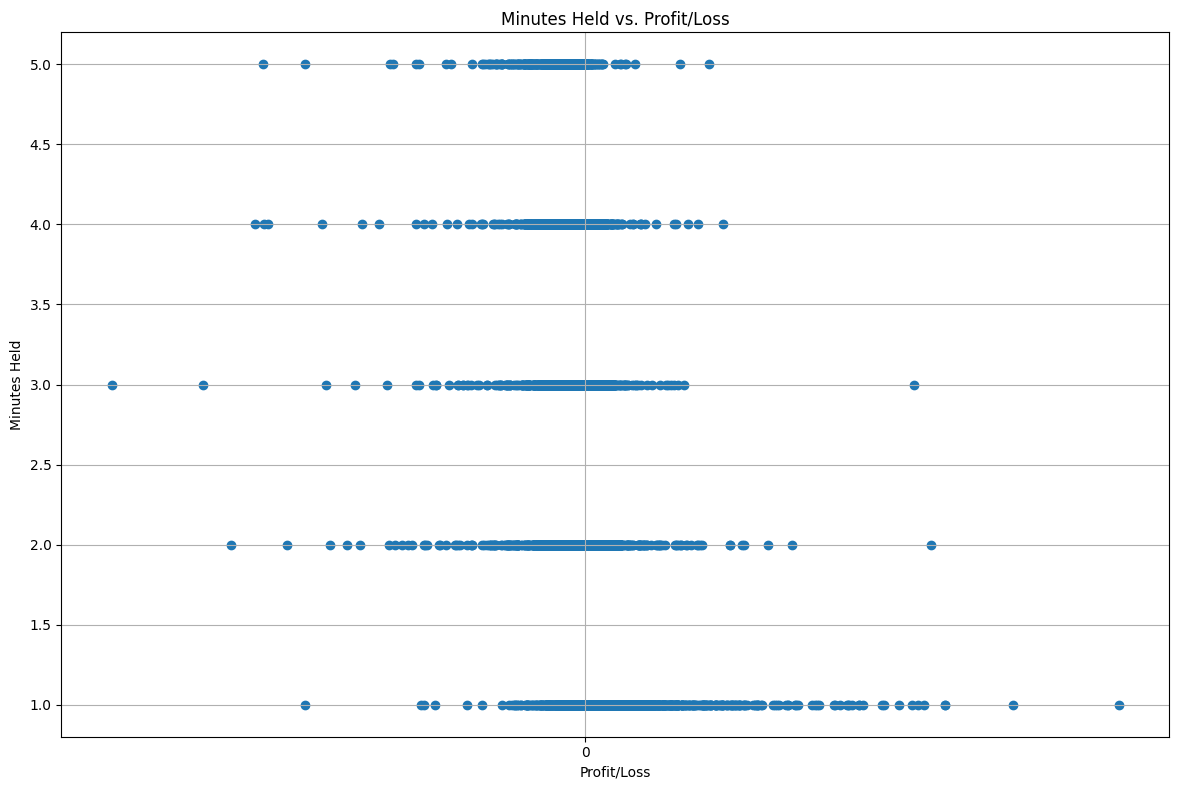

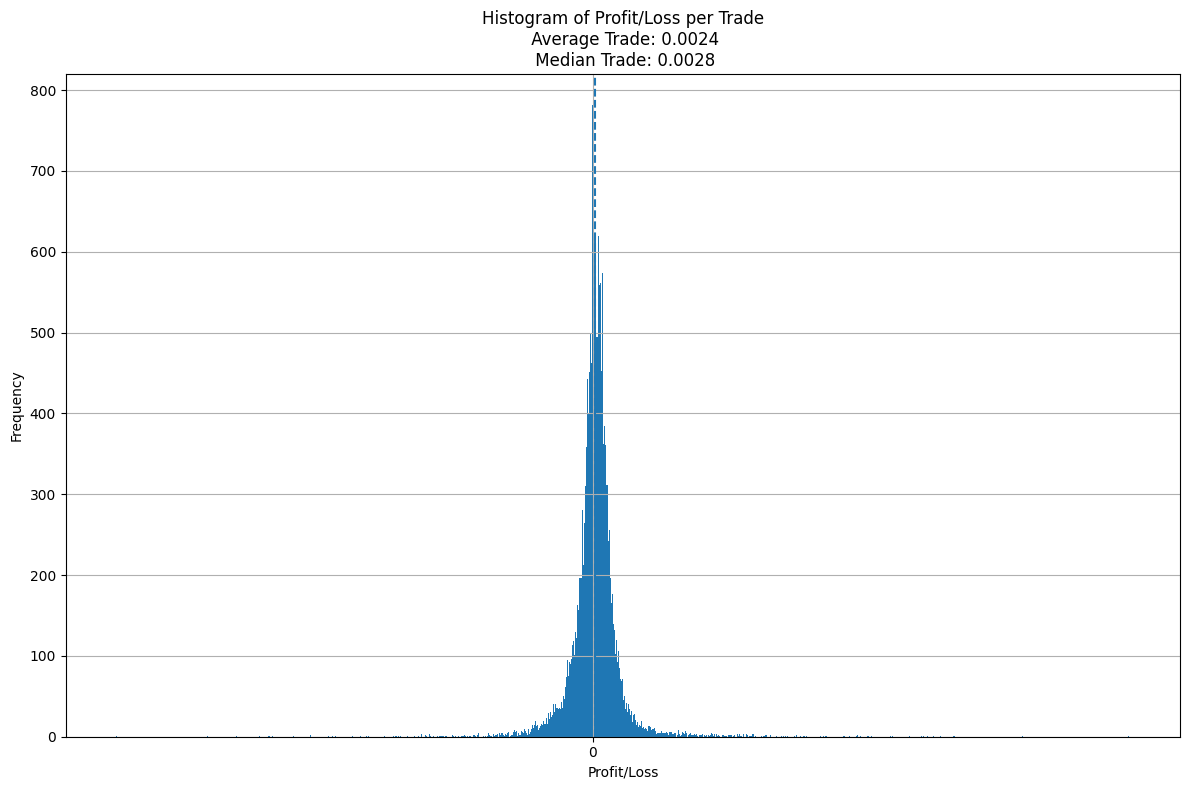

In [18]:
correct = [1 if x+y==2 else 0 for x, y in zip(labels, df_pl.label) ]
incorrect = [1 if x==1 and y == 0 else 0 for x, y in zip(labels, df_pl.label)]

# nostradamus_info is assuming we get all of the labels correct
correct_info = find_profit_loss(df_pl, correct, params, save_dir=save_dir+'correct')
incorrect_info = find_profit_loss(df_pl, incorrect, params, save_dir=save_dir+'incorrect')
nostradamus_info = find_profit_loss(df_pl, df_pl.label, params, save_dir=save_dir+'nostradamus')

# Results

### Trade Precision

In [19]:
pos_label = np.array([1 if x==1 and residual > 0 else 0 for x, residual in zip(labels, df_pl.residual)])
print(precision(pos_label, df_pl['label']))

0.9073439062723246


### Total P/L after 2 years

In [20]:
print(pl_info['total_profit'])

22.33991881189176


### Total Trades Executed

In [21]:
print(pl_info['trades_executed'])

13998


### Sharpe Ratio

In [22]:
print(pl_info['sharpe'])

4.012391391532584


## Comparison versus mean reversion strategy

In [23]:
df_tscore = pd.DataFrame()

for i in info:
    temp = i['test']['df']['price']
    df_tscore = pd.concat([df_tscore, temp], ignore_index=True)

[array([-1.32679572, -5.21367962]), array([1.29905097, 5.12361214])]


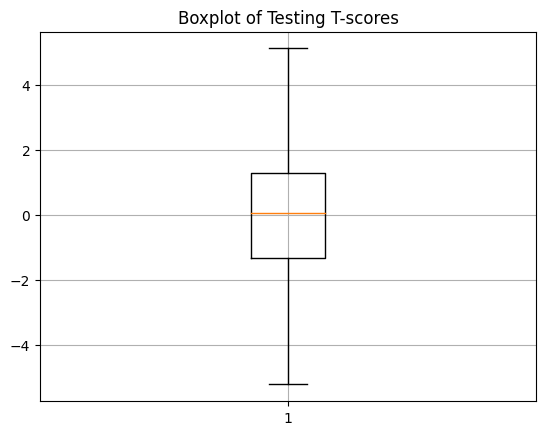

In [24]:
plt.figure()
plt.title('Boxplot of Testing T-scores')
a = plt.boxplot(df_tscore[0], showfliers=False)
plt.grid()
print([item.get_ydata() for item in a['whiskers']])

In [25]:
tscore_label = [1 if x > 0.8 else 0 for x in list(df_tscore[0])]

Finding Profit/Loss for model with parameters: C-100_cache_size-2000_class_weight-006_104_gamma-1_kernel-rbf.
0.9063660112745772
19.026356410180618
7273
4.135693500971602


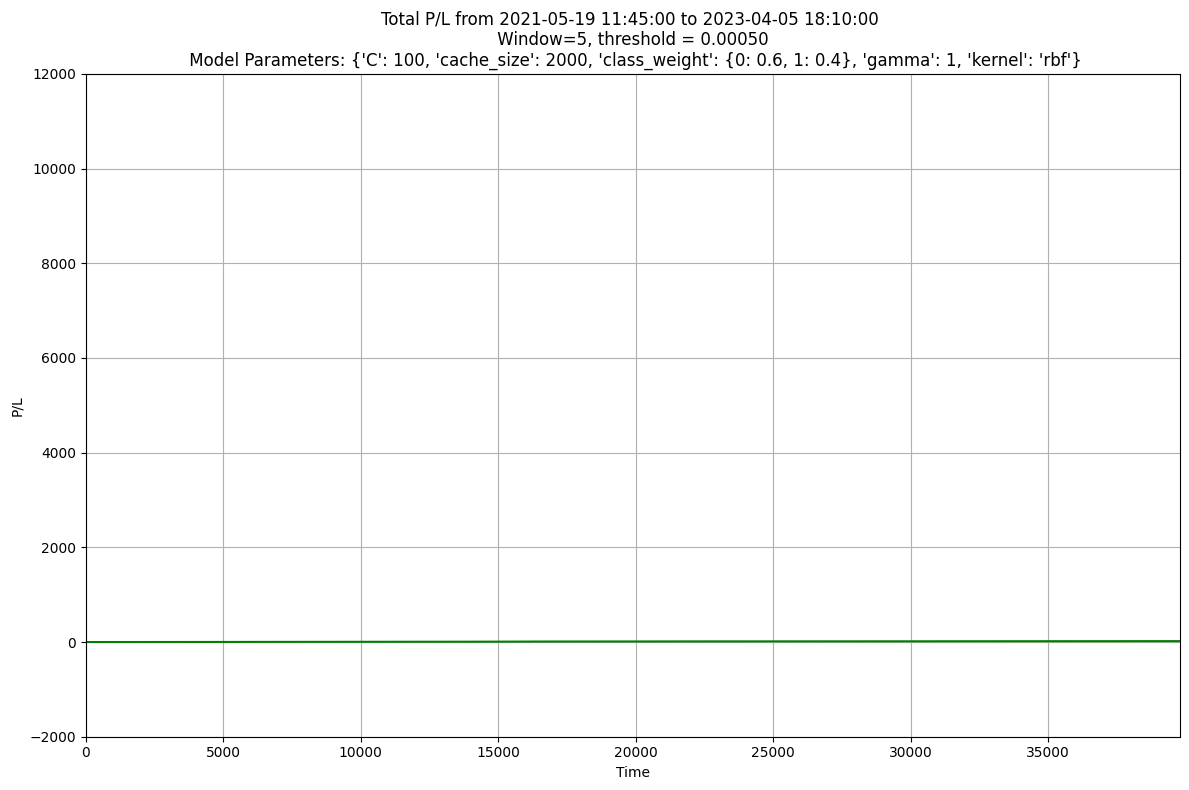

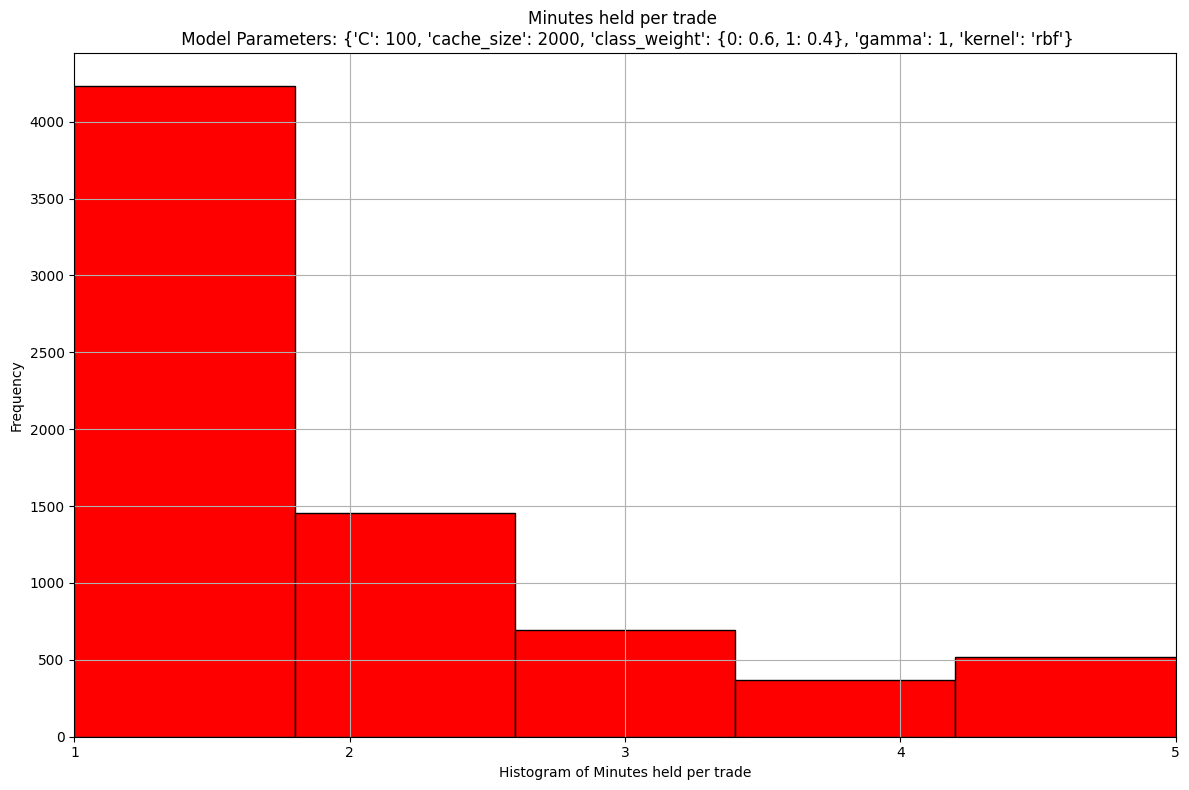

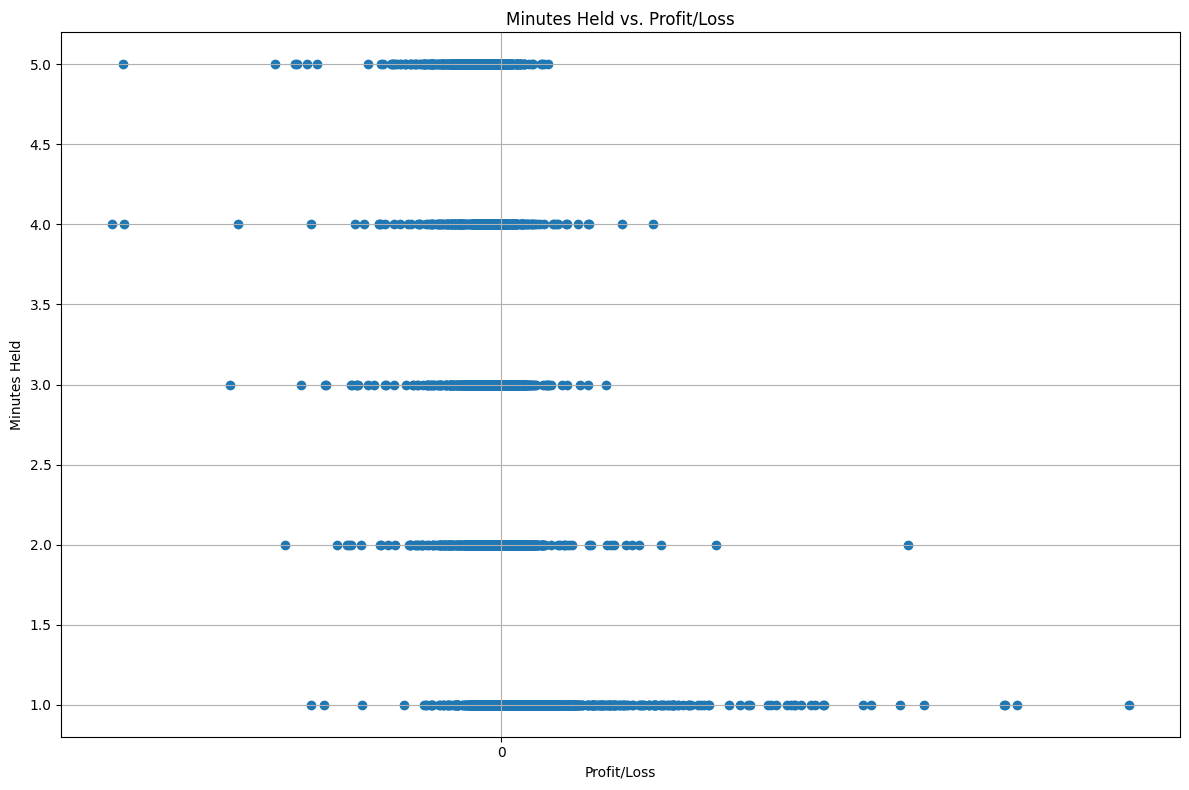

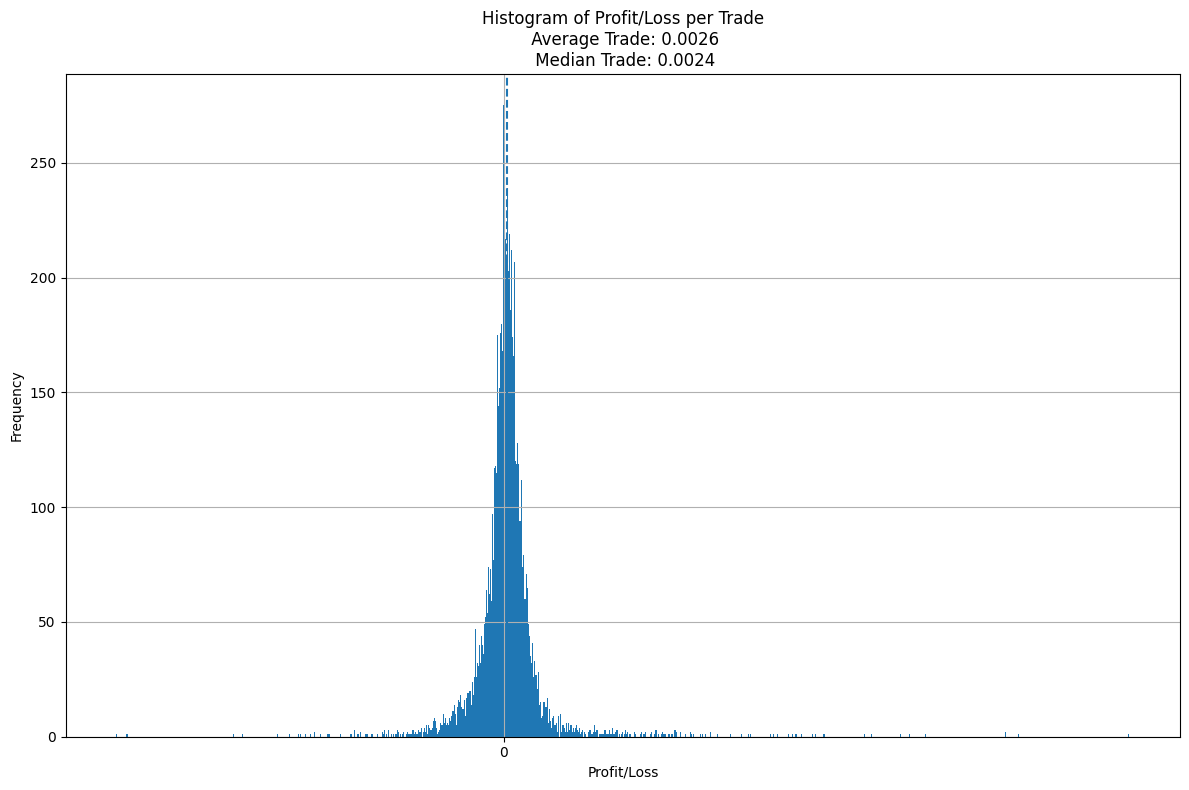

In [26]:
tscore_info = find_profit_loss(df_pl, tscore_label, params, save_dir=save_dir+'tscore')

tscore_pos_label = np.array([1 if x==1 and residual > 0 else 0 for x, residual in zip(tscore_label, df_pl.residual)])
print(precision(tscore_pos_label, df_pl['label']))

print(tscore_info['total_profit'])

print(tscore_info['trades_executed'])

print(tscore_info['sharpe'])